In [1]:
# (1) FUNCTIONS: Lorenz-63 in torch, observation helpers, neural update (DeepSets-style)

import torch
import torch.nn as nn
import torch.nn.functional as F

# ----- Lorenz-63 in torch -----
class Lorenz63Params:
    def __init__(self, sigma=10.0, rho=28.0, beta=8.0/3.0):
        self.sigma = sigma
        self.rho = rho
        self.beta = beta

def lorenz63_rhs(x, p: Lorenz63Params):
    if x.ndim == 1:  # single state (3,)
        dx = p.sigma * (x[1] - x[0])
        dy = x[0] * (p.rho - x[2]) - x[1]
        dz = x[0] * x[1] - p.beta * x[2]
        return torch.tensor([dx, dy, dz])
    else:            # batch of states (N,3)
        dx = p.sigma * (x[:,1] - x[:,0])
        dy = x[:,0] * (p.rho - x[:,2]) - x[:,1]
        dz = x[:,0] * x[:,1] - p.beta * x[:,2]
        return torch.stack([dx, dy, dz], dim=1)


def rk4_step(x, dt, f, params):
    k1 = f(x, params)
    k2 = f(x + 0.5*dt*k1, params)
    k3 = f(x + 0.5*dt*k2, params)
    k4 = f(x + dt*k3, params)
    return x + (dt/6.0)*(k1 + 2*k2 + 2*k3 + k4)

def integrate_l63(x0, params, dt, steps):
    X = [x0]
    x = x0
    for _ in range(steps):
        x = rk4_step(x, dt, lorenz63_rhs, params)
        X.append(x)
    return torch.stack(X)  # (steps+1,3)

# ----- Observation helpers -----
def make_obs_operator(select="xy"):
    if select == "xy":
        H = torch.tensor([[1.,0.,0.],[0.,1.,0.]])
    elif select == "full":
        H = torch.eye(3)
    else:
        H = torch.tensor([[1.,0.,0.],[0.,0.,1.]])  # x and z
    return H

def add_obs_noise(H, X, R_std, rng=torch):
    """
    X: (T,3), H:(m,3)
    returns Y: (T,m)
    """
    m = H.shape[0]
    Y = (H @ X.T).T
    noise = R_std * rng.randn(*Y.shape)
    return Y + noise

# ----- DeepSets neural update -----
class ParticleUpdateNN(nn.Module):
    def __init__(self, d_state=3, d_obs=2, hidden=64):
        super().__init__()
        # phi maps particle+obs -> embedding
        self.phi = nn.Sequential(
            nn.Linear(d_state+d_obs, hidden),
            nn.ReLU(),
            nn.Linear(hidden, hidden),
            nn.ReLU()
        )
        # rho maps pooled embedding -> global context
        self.rho = nn.Sequential(
            nn.Linear(hidden, hidden),
            nn.ReLU()
        )
        # psi maps (particle+context+obs) -> particle increment
        self.psi = nn.Sequential(
            nn.Linear(d_state+hidden+d_obs, hidden),
            nn.ReLU(),
            nn.Linear(hidden, d_state)
        )
    def forward(self, Xb, y):
        """
        Xb: (N,d_state), y:(d_obs,)
        returns Xa: (N,d_state)
        """
        N = Xb.shape[0]
        y_rep = y.expand(N,-1)
        inp = torch.cat([Xb,y_rep], dim=1)  # (N,d_state+d_obs)
        emb = self.phi(inp)                 # (N,hidden)
        pooled = emb.mean(dim=0, keepdim=True)  # (1,hidden)
        context = self.rho(pooled).expand(N,-1) # (N,hidden)
        out_inp = torch.cat([Xb,context,y_rep], dim=1)
        dX = self.psi(out_inp)
        Xa = Xb + dX
        return Xa


In [2]:
# (2) TRUTH & OBSERVATIONS

torch.manual_seed(1)

params_true = Lorenz63Params()
dt_assim = 0.1
Nt = 150

# truth trajectory
x0_true = torch.tensor([1.0,1.0,20.0])
X_truth = integrate_l63(x0_true, params_true, dt_assim, Nt)  # (Nt+1,3)

# obs operator: observe x,y
H = make_obs_operator("xy")
R_std = 0.1
Y = add_obs_noise(H, X_truth, R_std)

print("Truth:", X_truth.shape, " Obs:", Y.shape)


Truth: torch.Size([151, 3])  Obs: torch.Size([151, 2])


In [3]:
# -------------------------------
# Helpers for background term
# -------------------------------
def log_mixture_iso(Z, M, s2):
    """
    Isotropic Gaussian mixture log-pdf at points Z from component means M.
    Z: (K, d), M: (N, d), s2: scalar variance
    returns: (K,)
    """
    K, d = Z.shape
    N = M.shape[0]
    # pairwise squared distances (K,N)
    # (z - m)^2 = z^2 + m^2 - 2 z·m
    z2 = (Z**2).sum(dim=1, keepdim=True)          # (K,1)
    m2 = (M**2).sum(dim=1, keepdim=True).T        # (1,N)
    D2 = z2 + m2 - 2.0 * (Z @ M.T)                # (K,N)

    log_norm = -0.5 * (d * torch.log(2*torch.pi*s2) + D2 / s2)  # (K,N)
    log_mix = torch.logsumexp(log_norm - torch.log(torch.tensor(N, dtype=Z.dtype, device=Z.device)), dim=1)  # (K,)
    return log_mix

def obs_loglik_points(y, Z, H, R_std):
    """
    Log-likelihood at points Z under Gaussian obs: y ~ N(H z, R)
    Z: (K,d), y: (m,), H: (m,d), R = R_std^2 I
    returns: (K,)
    """
    device, dtype = Z.device, Z.dtype
    Yp = (H @ Z.T).T                          # (K,m)
    innov = y.unsqueeze(0) - Yp               # (K,m)
    quad = (innov**2).sum(dim=1) / (R_std**2) # (K,)
    m = y.shape[0]

    const_val = 2 * torch.pi * (R_std**2)
    const = m * torch.log(torch.tensor(const_val, device=device, dtype=dtype))
    return -0.5 * (quad + const)


def kalman_eval_points(Xb, y, H, R_std, eps=1e-6):
    """
    Build evaluation points Z by applying a *single* Kalman update to each forecast particle x^b_i,
    using an ensemble-diagonal background covariance.
    Returns Z: (N,d)
    """
    N, d = Xb.shape
    device, dtype = Xb.device, Xb.dtype
    # diagonal ensemble covariance as background P (d,d)
    var_b = Xb.var(dim=0, unbiased=False) + eps
    P = torch.diag(var_b)                      # (d,d)
    R = (R_std**2) * torch.eye(H.shape[0], device=device, dtype=dtype)  # (m,m)
    HPHT = H @ P @ H.T                         # (m,m)
    S = HPHT + R                               # (m,m)
    K = P @ H.T @ torch.linalg.inv(S)          # (d,m)

    # per-particle innovation and update
    Yb = (H @ Xb.T).T                          # (N,m)
    innov = y.unsqueeze(0) - Yb                # (N,m)
    Z = Xb + innov @ K.T                       # (N,d)
    return Z

# -------------------------------
# Original obs likelihood (per-particle)
# -------------------------------
def obs_likelihood(y, Xa, H, R_std):
    Yp = (H @ Xa.T).T
    innov = y - Yp
    quad = (innov**2).sum(dim=1) / (R_std**2)
    const = Xa.new_tensor(2*torch.pi*(R_std**2))
    m = y.shape[0]
    loglik = -0.5 * (quad + m * torch.log(const))
    return loglik

# -------------------------------
# TRAINING LOOP with background term
# -------------------------------
d_state = 3; d_obs = H.shape[0]
net = ParticleUpdateNN(d_state, d_obs, hidden=64)
opt = torch.optim.Adam(net.parameters(), lr=1e-3)

Npart = 20
nsub = 5
model_std = 0.20
params_model = Lorenz63Params(sigma=11.0, rho=28.0, beta=8/3)

# initial analysis ensemble (biased start)
x0_bias = X_truth[0] + torch.tensor([2.0, -2.0, 3.0], dtype=X_truth.dtype, device=X_truth.device)
Xa_prev = x0_bias.expand(Npart, 3) + 2.0 * torch.randn(Npart, 3, dtype=X_truth.dtype, device=X_truth.device)

losses = []

# background-loss knobs
lambda_bg = 0.5        # weight of background KL term
tau_b = 0.7            # kernel width factor for prior mixture
tau_a = 0.7            # kernel width factor for analysis mixture
eps_var = 1e-6

for epoch in range(501):
    total_loss = 0.0
    # (optional) reinit each epoch
    Xa_prev = x0_bias.expand(Npart, 3) + 2.0 * torch.randn(Npart, 3, dtype=X_truth.dtype, device=X_truth.device)

    for n in range(Nt):
        # ---- Forecast: Xa_prev -> Xb
        Xb = Xa_prev
        h = dt_assim / nsub
        for _ in range(nsub):
            Xb = rk4_step(Xb, h, lorenz63_rhs, params_model)
        if model_std > 0:
            Xb = Xb + model_std * torch.randn_like(Xb)

        # ---- Analysis via neural update
        y = Y[n]                     # (m,)
        Xa = net(Xb, y)              # (N,d)

        # ---------------------------
        # Loss part A: obs-only loss
        # ---------------------------
        loglik = obs_likelihood(y, Xa, H, R_std)
        loss_obs = -(torch.logsumexp(loglik, dim=0) - torch.log(torch.tensor(Npart, dtype=X_truth.dtype, device=X_truth.device)))

        # ---------------------------
        # Loss part B: background KL on mixtures at Kalman-eval points
        # ---------------------------
        with torch.no_grad():
            # evaluation points by single-Kalman update from each forecast particle
            Z = kalman_eval_points(Xb, y, H, R_std)   # (N,d)

            # isotropic mixture variances from ensemble spread (detach to avoid backprop through bandwidth)
            var_b = Xb.var(dim=0, unbiased=False).mean() + eps_var
            var_a = Xa.var(dim=0, unbiased=False).mean() + eps_var
            s2_b = (tau_b**2) * var_b
            s2_a = (tau_a**2) * var_a

        # target posterior over Z: proportional to q_b(Z) * p(y|Z), normalized over Z
        log_qb_Z = log_mixture_iso(Z, Xb, s2_b)               # (N,)
        log_py_Z = obs_loglik_points(y, Z, H, R_std)          # (N,)
        log_target_unnorm = log_qb_Z + log_py_Z               # (N,)
        logw_target = log_target_unnorm - torch.logsumexp(log_target_unnorm, dim=0)
        w_target = torch.exp(logw_target)                     # (N,), sums to 1

        # model mixture over Z from Xa
        log_qa_Z = log_mixture_iso(Z, Xa, s2_a)               # (N,)
        logw_model = log_qa_Z - torch.logsumexp(log_qa_Z, dim=0)
        # KL(target || model) = sum w_target * (log w_target - log w_model)
        loss_bg = (w_target * (logw_target - logw_model)).sum()

        # ---------------------------
        # Total loss
        # ---------------------------
        loss = loss_obs + lambda_bg * loss_bg

        opt.zero_grad()
        loss.backward()
        opt.step()

        total_loss += loss.item()
        Xa_prev = Xa.detach()

    losses.append(total_loss / Nt)
    if epoch % 50 == 0:
        print(f"Epoch {epoch:3d}, avg loss {losses[-1]:.4f}")


Epoch   0, avg loss 2187.9058
Epoch  50, avg loss 4.1278
Epoch 100, avg loss -0.2776
Epoch 150, avg loss -0.8285
Epoch 200, avg loss -0.7599
Epoch 250, avg loss -0.7595
Epoch 300, avg loss -0.6791
Epoch 350, avg loss -0.8570
Epoch 400, avg loss -1.4149
Epoch 450, avg loss -2.0777
Epoch 500, avg loss -1.9198


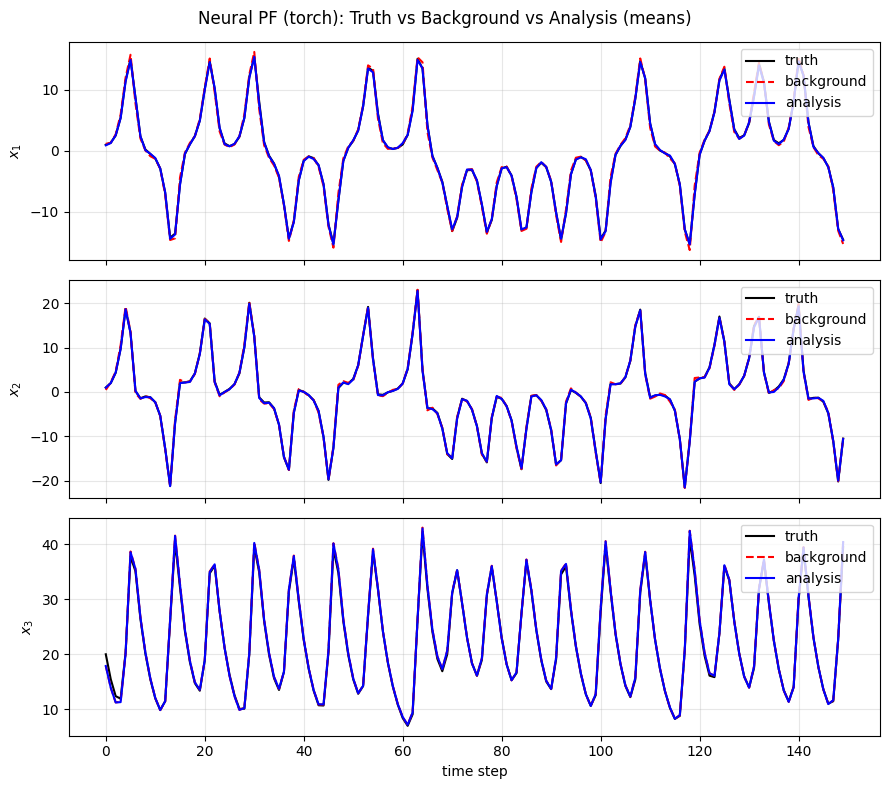

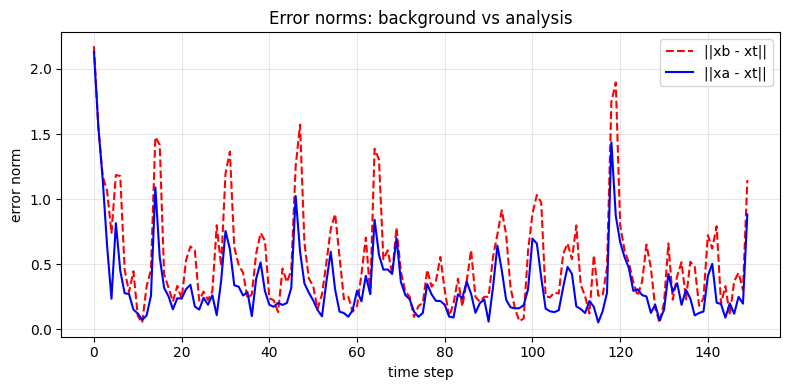

Average background error: 0.525
Average analysis error:   0.336


In [4]:
# (4) EVALUATION & VISUALIZATION: forecast-based xb, NN-based xa, errors
# Uses Npart, params_model, nsub, model_std, dt_assim, net, X_truth, Y from above.

import matplotlib.pyplot as plt
import torch

Xb_means = []
Xa_means = []

# initial analysis ensemble (same style as training)
device = X_truth.device
dtype  = X_truth.dtype
x0_bias = X_truth[0] + torch.tensor([2.0, -2.0, 3.0], device=device, dtype=dtype)
Xa_prev = x0_bias.expand(Npart, 3) + 2.0 * torch.randn(Npart, 3, device=device, dtype=dtype)

for n in range(Nt):
    # ---- Forecast: Xa_prev -> Xb with wrong model (sigma=11)
    Xb = Xa_prev
    h = dt_assim / nsub
    for _ in range(nsub):
        Xb = rk4_step(Xb, h, lorenz63_rhs, params_model)

    if model_std > 0:
        Xb = Xb + model_std * torch.randn_like(Xb)

    Xb_means.append(Xb.mean(dim=0))

    # ---- Analysis via neural update
    y = Y[n]                # observation at time n
    Xa = net(Xb, y)
    #Xa = Xb
    Xa_means.append(Xa.mean(dim=0))

    # next cycle
    Xa_prev = Xa.detach()

Xb_means = torch.stack(Xb_means)   # (Nt,3)
Xa_means = torch.stack(Xa_means)   # (Nt,3)
Xt = X_truth[:-1]                  # (Nt,3)

# ---- component time series ----
labels = [r"$x_1$", r"$x_2$", r"$x_3$"]
fig, axs = plt.subplots(3, 1, figsize=(9, 8), sharex=True)
for i in range(3):
    axs[i].plot(Xt[:, i].detach().cpu().numpy(), 'k-', label="truth")
    axs[i].plot(Xb_means[:, i].detach().cpu().numpy(), 'r--', label="background")
    axs[i].plot(Xa_means[:, i].detach().cpu().numpy(), 'b-', label="analysis")
    axs[i].set_ylabel(labels[i])
    axs[i].grid(alpha=0.3)
    axs[i].legend(loc="upper right")
axs[-1].set_xlabel("time step")
fig.suptitle("Neural PF (torch): Truth vs Background vs Analysis (means)")
plt.tight_layout()
plt.savefig("f_lorenz63_aipf.png")
plt.show()

# ---- error norms over time ----
err_b = torch.norm(Xb_means - Xt, dim=1)   # ||xb - xt||
err_a = torch.norm(Xa_means - Xt, dim=1)   # ||xa - xt||

plt.figure(figsize=(8, 4))
plt.plot(err_b.detach().cpu().numpy(), 'r--', label="||xb - xt||")
plt.plot(err_a.detach().cpu().numpy(), 'b-', label="||xa - xt||")
plt.xlabel("time step")
plt.ylabel("error norm")
plt.title("Error norms: background vs analysis")
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.savefig("f_pf_error.png")
plt.show()

# ---- average errors (mean over time) ----
avg_err_b = err_b.mean().item()
avg_err_a = err_a.mean().item()
print(f"Average background error: {avg_err_b:.3f}")
print(f"Average analysis error:   {avg_err_a:.3f}")


In [5]:
# (5) ENSEMBLE SCATTER: stacked subplots, each with its own legend, incl. xb/xa means + obs cross

import numpy as np
import matplotlib.pyplot as plt
import torch

# --- settings ---
num_panels = 8
plane = "xy"  # {"xy","xz","yz"}
idx_map = {"xy": (0,1), "xz": (0,2), "yz": (1,2)}
i, j = idx_map[plane]

# pick evenly spaced assimilation indices (exclude 0)
sample_idx = np.linspace(1, Nt-1, num_panels, dtype=int)
sample_idx = np.unique(sample_idx)

# --- capture ensembles ---
device = X_truth.device
dtype  = X_truth.dtype

x0_bias = X_truth[0] + torch.tensor([2.0, -2.0, 3.0], device=device, dtype=dtype)
Xa_prev = x0_bias.expand(Npart, 3) + 2.0 * torch.randn(Npart, 3, device=device, dtype=dtype)

captured = []
for n in range(Nt):
    # Forecast
    Xb = Xa_prev
    h = dt_assim / nsub
    for _ in range(nsub):
        Xb = rk4_step(Xb, h, lorenz63_rhs, params_model)
    if model_std > 0:
        Xb = Xb + model_std * torch.randn_like(Xb)

    y = Y[n]
    Xa = net(Xb, y)

    if n in sample_idx:
        xt = X_truth[n]
        err_b = torch.norm(Xb.mean(dim=0) - xt).item()
        err_a = torch.norm(Xa.mean(dim=0) - xt).item()
        captured.append({
            "n": n,
            "xt": xt.detach().cpu(),
            "Xb": Xb.detach().cpu(),
            "Xa": Xa.detach().cpu(),
            "y": y.detach().cpu(),
            "err_b": err_b,
            "err_a": err_a,
        })

    Xa_prev = Xa.detach()

# --- plotting & saving ---
rows = len(captured)
for snap in captured:
    n = snap["n"]
    xt = snap["xt"].numpy()
    Xb = snap["Xb"].numpy()
    Xa = snap["Xa"].numpy()
    y = snap["y"].numpy()

    fig, ax = plt.subplots(figsize=(6, 4))

    # ensemble members
    ax.scatter(Xb[:, i], Xb[:, j], s=15, alpha=0.4, c="red", label="forecast ens")
    ax.scatter(Xa[:, i], Xa[:, j], s=15, alpha=0.4, marker="^", c="blue", label="analysis ens")
    ax.scatter([xt[i]], [xt[j]], s=90, marker="*", c="gold", edgecolor="k", label="truth")

    # means
    mu_b = Xb.mean(axis=0); mu_a = Xa.mean(axis=0)
    ax.scatter([mu_b[i]], [mu_b[j]], s=80, edgecolor="k", facecolor="none", label="xb mean")
    ax.scatter([mu_a[i]], [mu_a[j]], s=80, edgecolor="k", facecolor="none", marker="s", label="xa mean")

    # observation cross (project back if H only observes subset)
    obs_coords = np.full(3, np.nan)  # fill missing with NaN
    # reconstruct in state-space if H is selection matrix
    obs_idx = np.where(H.sum(axis=1).numpy() == 1)[0] if isinstance(H, torch.Tensor) else []
    if len(obs_idx) > 0:
        for k in range(len(y)):
            j_state = int(torch.argmax(H[k]).item()) if isinstance(H, torch.Tensor) else None
            obs_coords[j_state] = y[k]
    # plot only if both coords are available
    if not np.isnan(obs_coords[i]) and not np.isnan(obs_coords[j]):
        ax.scatter([obs_coords[i]], [obs_coords[j]],
                   s=90, marker="x", c="black", label="observation")

    ax.set_title(f"step n={n} | ||xb-xt||={snap['err_b']:.2f}, ||xa-xt||={snap['err_a']:.2f}")
    ax.set_xlabel(f"x_{i+1}")
    ax.set_ylabel(f"x_{j+1}")
    ax.grid(alpha=0.3)
    ax.legend(loc="best", frameon=False)

    fig.suptitle(f"Ensemble scatter in $x_{{{i+1}}}$–$x_{{{j+1}}}$ plane", fontsize=12)
    fig.tight_layout(rect=[0, 0, 1, 0.96])

    # save figure with time step in filename
    fname = f"f_ensemble_scatter_step_{n:04d}.png"
    fig.savefig(fname, dpi=150)
    print(f"Saved {fname}")

    plt.close(fig)  # close to avoid memory buildup

# error table
print("Step |  ||xb-xt||   ||xa-xt||")
for snap in captured:
    print(f"{snap['n']:4d} |  {snap['err_b']:9.3f}  {snap['err_a']:9.3f}")


Saved f_ensemble_scatter_step_0001.png
Saved f_ensemble_scatter_step_0022.png
Saved f_ensemble_scatter_step_0043.png
Saved f_ensemble_scatter_step_0064.png
Saved f_ensemble_scatter_step_0085.png
Saved f_ensemble_scatter_step_0106.png
Saved f_ensemble_scatter_step_0127.png
Saved f_ensemble_scatter_step_0149.png
Step |  ||xb-xt||   ||xa-xt||
   1 |      1.896      1.903
  22 |      0.589      0.345
  43 |      0.437      0.100
  64 |      1.597      0.935
  85 |      0.470      0.432
 106 |      0.217      0.169
 127 |      0.511      0.080
 149 |      1.295      1.022


In [6]:
# Define two separate networks
d_state = 3; d_obs = H.shape[0]

net_bg  = ParticleUpdateNN(d_state, d_obs, hidden=64)
opt_bg  = torch.optim.Adam(net_bg.parameters(), lr=1e-3)

net_obs = ParticleUpdateNN(d_state, d_obs, hidden=64)
opt_obs = torch.optim.Adam(net_obs.parameters(), lr=1e-3)


In [7]:
losses_obs = []

for epoch in range(501):
    total_loss = 0.0
    Xa_prev = x0_bias.expand(Npart, 3) + 2.0 * torch.randn(
        Npart, 3, dtype=X_truth.dtype, device=X_truth.device
    )

    for n in range(Nt):
        # Forecast
        Xb = Xa_prev
        h = dt_assim / nsub
        for _ in range(nsub):
            Xb = rk4_step(Xb, h, lorenz63_rhs, params_model)
        if model_std > 0:
            Xb = Xb + model_std * torch.randn_like(Xb)

        # Analysis
        y = Y[n]
        Xa = net_obs(Xb, y)

        # --- obs loss only
        loglik = obs_likelihood(y, Xa, H, R_std)
        loss = -(torch.logsumexp(loglik, dim=0) -
                 torch.log(torch.tensor(Npart, dtype=X_truth.dtype, device=X_truth.device)))

        opt_obs.zero_grad()
        loss.backward()
        opt_obs.step()

        total_loss += loss.item()
        Xa_prev = Xa.detach()

    losses_obs.append(total_loss / Nt)
    if epoch % 50 == 0:
        print(f"[OBS] Epoch {epoch:3d}, avg loss {losses_obs[-1]:.4f}")


[OBS] Epoch   0, avg loss 649.7240
[OBS] Epoch  50, avg loss 0.1509
[OBS] Epoch 100, avg loss -0.2555
[OBS] Epoch 150, avg loss -0.7811
[OBS] Epoch 200, avg loss -0.9250
[OBS] Epoch 250, avg loss -0.7729
[OBS] Epoch 300, avg loss -1.6335
[OBS] Epoch 350, avg loss -1.7501
[OBS] Epoch 400, avg loss -2.0803
[OBS] Epoch 450, avg loss -1.5922
[OBS] Epoch 500, avg loss -1.6182


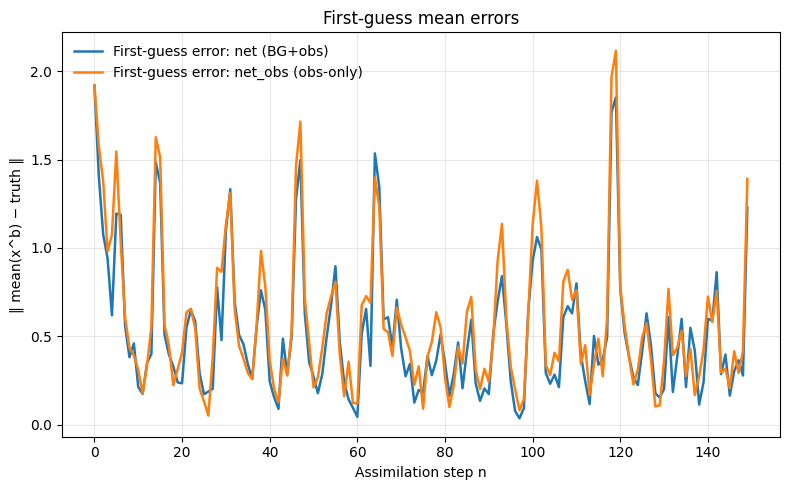

Saved fg_errors_net_vs_netobs.png


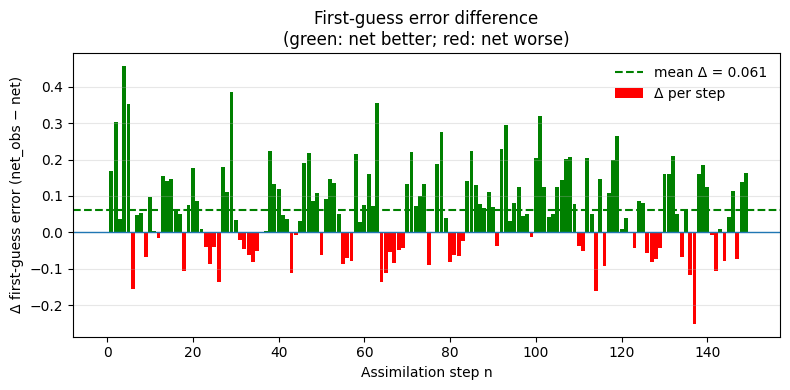

Saved fg_error_diff_netobs_minus_net.png


In [8]:
# -----------------------------------------
# Evaluation: First-Guess (Forecast) Errors
# net (BG+obs) vs net_obs (obs-only)
# -----------------------------------------
import numpy as np
import matplotlib.pyplot as plt
import torch

# Safety: both nets must exist and be trained already
assert 'net' in globals(), "Expected trained `net` (BG+obs)."
assert 'net_obs' in globals(), "Expected trained `net_obs` (obs-only)."

# eval mode + no grad
net.eval()
net_obs.eval()

with torch.no_grad():
    # deterministic initial ensemble (same for both)
    g = torch.Generator(device=X_truth.device).manual_seed(42)
    Xa0 = x0_bias.expand(Npart, 3) + 2.0 * torch.randn(
        Npart, 3, dtype=X_truth.dtype, device=X_truth.device, generator=g
    )
    Xa_prev_net     = Xa0.clone()
    Xa_prev_net_obs = Xa0.clone()

    # no stochastic model noise at eval (keeps comparison clean)
    eval_model_std = 0.0

    def forecast_step(Xa_prev):
        Xb = Xa_prev
        h = dt_assim / nsub
        for _ in range(nsub):
            Xb = rk4_step(Xb, h, lorenz63_rhs, params_model)
        if eval_model_std > 0:
            noise = torch.randn_like(Xb, generator=g)
            Xb = Xb + eval_model_std * noise
        return Xb

    # Collect FIRST-GUESS (forecast) mean errors
    fg_err_net, fg_err_net_obs = [], []

    for n in range(Nt):
        # forecasts from previous analyses
        Xb_net     = forecast_step(Xa_prev_net)
        Xb_net_obs = forecast_step(Xa_prev_net_obs)

        # first-guess mean errors vs truth
        xt = X_truth[n]
        fg_err_net.append(torch.norm(Xb_net.mean(dim=0)     - xt).item())
        fg_err_net_obs.append(torch.norm(Xb_net_obs.mean(dim=0) - xt).item())

        # analyses to advance for next step
        y = Y[n]
        Xa_net     = net(Xb_net, y)
        Xa_net_obs = net_obs(Xb_net_obs, y)
        Xa_prev_net     = Xa_net
        Xa_prev_net_obs = Xa_net_obs

# ------------------ Plot 1: two curves ------------------
fig, ax = plt.subplots(figsize=(8,5))
ax.plot(fg_err_net,     label="First-guess error: net (BG+obs)",  linewidth=1.8)
ax.plot(fg_err_net_obs, label="First-guess error: net_obs (obs-only)", linewidth=1.8)
ax.set_xlabel("Assimilation step n")
ax.set_ylabel("‖ mean(x^b) − truth ‖")
ax.set_title("First-guess mean errors")
ax.grid(alpha=0.3)
ax.legend(frameon=False)
fig.tight_layout()
fig.savefig("fg_errors_net_vs_netobs.png", dpi=150)
plt.show()
print("Saved fg_errors_net_vs_netobs.png")

# ------------------ Plot 2: difference with colors + mean line ------------------
# diff = net_obs − net  (positive => net better => green)
diff = np.array(fg_err_net_obs) - np.array(fg_err_net)
idx = np.arange(len(diff))
colors = np.where(diff > 0.0, "green", "red")

mean_diff = float(diff.mean())

fig, ax = plt.subplots(figsize=(8,4))
ax.bar(idx, diff, color=colors, width=0.9, label="Δ per step")
ax.axhline(0.0, linewidth=1.0)
ax.axhline(mean_diff, linestyle="--", linewidth=1.5, color='green', label=f"mean Δ = {mean_diff:.3f}")

ax.set_xlabel("Assimilation step n")
ax.set_ylabel("Δ first-guess error (net_obs − net)")
ax.set_title("First-guess error difference\n(green: net better; red: net worse)")
ax.grid(axis="y", alpha=0.3)
ax.legend(frameon=False, loc="best")

fig.tight_layout()
fig.savefig("fg_error_diff_netobs_minus_net.png", dpi=150)
plt.show()
print("Saved fg_error_diff_netobs_minus_net.png")



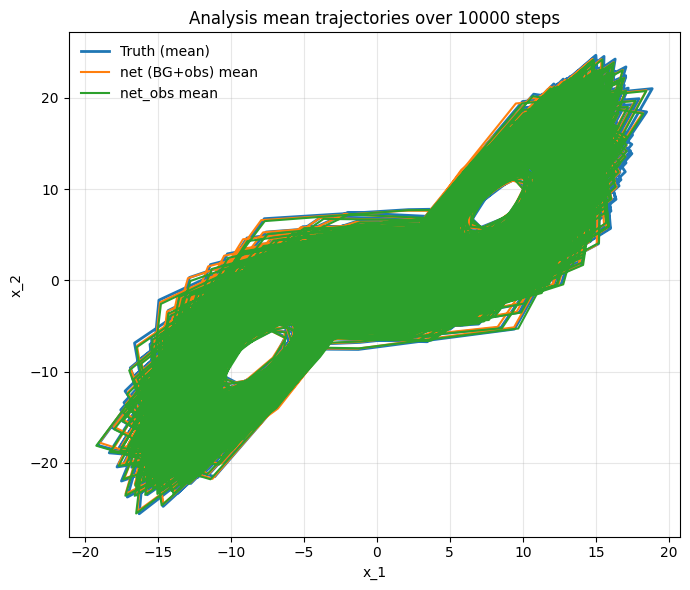

Saved traj_analysis_means_x1x2.png


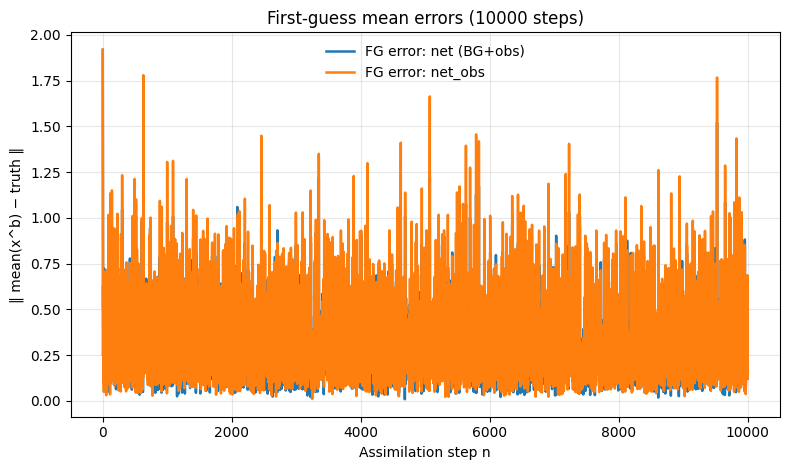

Saved fg_errors_10000.png


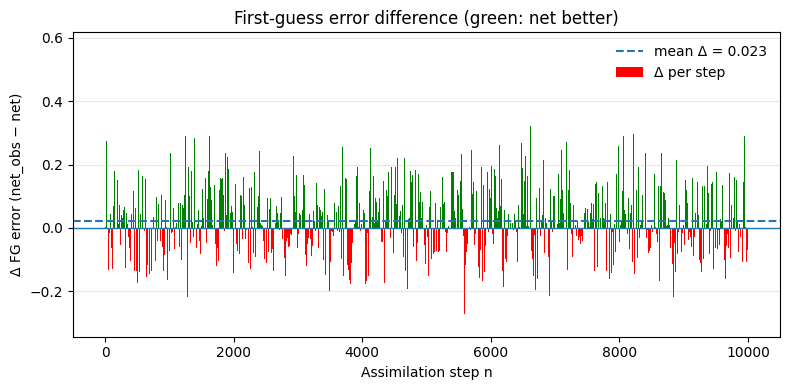

Saved fg_error_diff_10000.png


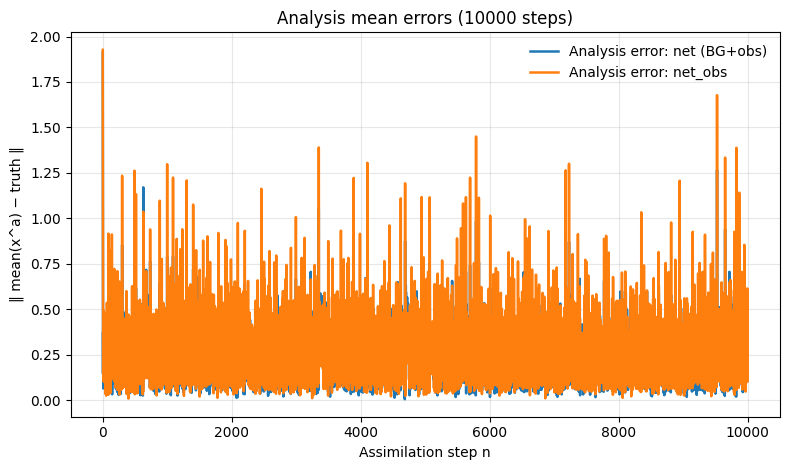

Saved an_errors_300.png


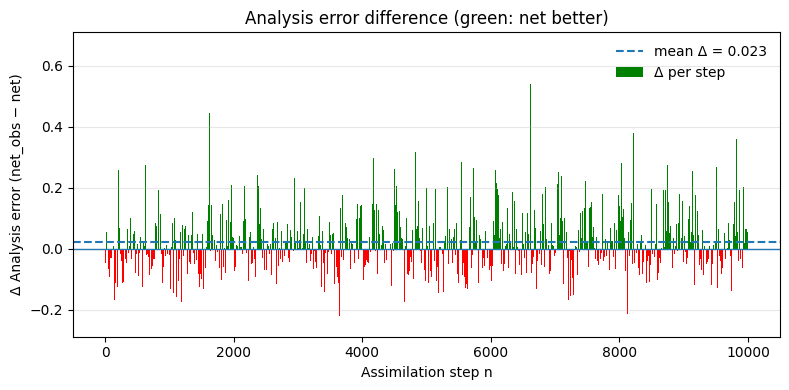

Saved an_error_diff_300.png


In [9]:
# =========================================
# Final 300-step test:
# 1) generate obs
# 2) run both nets in parallel
# 3) show trajectories
# 4) comparison plots (FG & Analysis)
# =========================================
import numpy as np
import matplotlib.pyplot as plt
import torch

# ---- Safety checks: trained models must exist
assert 'net' in globals(), "Expected trained `net` (BG+obs)."
assert 'net_obs' in globals(), "Expected trained `net_obs` (obs-only)."

# ---- Config
Nt_eval = 10000
plane_i, plane_j = 0, 1   # x1-x2 plane for trajectory plot
eval_model_std = 0.0      # keep eval deterministic
device = X_truth.device if 'X_truth' in globals() else torch.device('cpu')
dtype  = X_truth.dtype  if 'X_truth' in globals() else torch.float32

# ---- True dynamics (fallback if params_true not provided)
params_true = globals().get('params_true', Lorenz63Params(sigma=10.0, rho=28.0, beta=8/3))

# ---- Observations: need H and R_std from your setup
assert 'H' in globals() and 'R_std' in globals(), "Require H and R_std."
H_eval = H.to(device=device, dtype=dtype)
R_std_eval = float(R_std)

# ---- Generate truth + obs for Nt_eval
@torch.no_grad()
def gen_truth_and_obs(Nt, x0_truth=None, gseed=1234):
    g = torch.Generator(device=device).manual_seed(gseed)
    if x0_truth is None:
        if 'X_truth' in globals() and X_truth.shape[0] > 0:
            x0_truth = X_truth[0].to(device=device, dtype=dtype)
        else:
            x0_truth = torch.tensor([1.0, 1.0, 1.0], device=device, dtype=dtype)

    X_true = torch.empty((Nt, 3), device=device, dtype=dtype)
    X_true[0] = x0_truth

    # integrate truth with same dt/nsub you used elsewhere
    assert 'dt_assim' in globals() and 'nsub' in globals(), "Need dt_assim and nsub."
    h = dt_assim / nsub
    x = x0_truth.clone()
    for n in range(1, Nt):
        xb = x.unsqueeze(0)
        for _ in range(nsub):
            xb = rk4_step(xb, h, lorenz63_rhs, params_true)
        x = xb.squeeze(0)
        X_true[n] = x

    # observations y_n = H x_n + eps, eps ~ N(0, R_std^2 I)
    m = H_eval.shape[0]
    noise = R_std_eval * torch.randn((Nt, m), generator=g, device=device, dtype=dtype)
    Y_eval = (H_eval @ X_true.T).T + noise
    return X_true, Y_eval

X_true_eval, Y_eval = gen_truth_and_obs(Nt_eval)

# ---- Evaluation: run both nets from same deterministic initial ensemble
net.eval(); net_obs.eval()
with torch.no_grad():
    g = torch.Generator(device=device).manual_seed(42)
    # biased init around truth[0], same for both nets
    x0_bias_eval = X_true_eval[0] + torch.tensor([2.0, -2.0, 3.0], device=device, dtype=dtype)
    Xa0 = x0_bias_eval.expand(Npart, 3) + 2.0 * torch.randn(Npart, 3, device=device, dtype=dtype, generator=g)
    Xa_prev_net     = Xa0.clone()
    Xa_prev_net_obs = Xa0.clone()

    def forecast_step(Xa_prev):
        Xb = Xa_prev
        h = dt_assim / nsub
        for _ in range(nsub):
            Xb = rk4_step(Xb, h, lorenz63_rhs, params_model)  # wrong/approx model on purpose
        if eval_model_std > 0:
            Xb = Xb + eval_model_std * torch.randn_like(Xb, generator=g)
        return Xb

    # storage
    fg_err_net, fg_err_net_obs = [], []
    an_err_net, an_err_net_obs = [], []
    mean_net, mean_net_obs, mean_truth = [], [], []

    for n in range(Nt_eval):
        # forecast
        Xb_net     = forecast_step(Xa_prev_net)
        Xb_net_obs = forecast_step(Xa_prev_net_obs)

        # first-guess errors
        xt = X_true_eval[n]
        fg_err_net.append(torch.norm(Xb_net.mean(dim=0)     - xt).item())
        fg_err_net_obs.append(torch.norm(Xb_net_obs.mean(dim=0) - xt).item())

        # analysis (to advance)
        y = Y_eval[n]
        Xa_net     = net(Xb_net, y)
        Xa_net_obs = net_obs(Xb_net_obs, y)

        # analysis errors
        an_err_net.append(torch.norm(Xa_net.mean(dim=0)     - xt).item())
        an_err_net_obs.append(torch.norm(Xa_net_obs.mean(dim=0) - xt).item())

        # store trajectories (means)
        mean_net.append(Xa_net.mean(dim=0).cpu().numpy())
        mean_net_obs.append(Xa_net_obs.mean(dim=0).cpu().numpy())
        mean_truth.append(xt.cpu().numpy())

        # advance
        Xa_prev_net     = Xa_net
        Xa_prev_net_obs = Xa_net_obs

# numpy arrays for plotting
mean_net     = np.vstack(mean_net)
mean_net_obs = np.vstack(mean_net_obs)
mean_truth   = np.vstack(mean_truth)
fg_err_net     = np.asarray(fg_err_net)
fg_err_net_obs = np.asarray(fg_err_net_obs)
an_err_net     = np.asarray(an_err_net)
an_err_net_obs = np.asarray(an_err_net_obs)

# ---- 1) Trajectories plot (analysis means vs truth)
fig, ax = plt.subplots(figsize=(7,6))
ax.plot(mean_truth[:, plane_i],   mean_truth[:, plane_j],   label="Truth (mean)",      linewidth=2.0)
ax.plot(mean_net[:, plane_i],     mean_net[:, plane_j],     label="net (BG+obs) mean", linewidth=1.5)
ax.plot(mean_net_obs[:, plane_i], mean_net_obs[:, plane_j], label="net_obs mean",      linewidth=1.5)
ax.set_xlabel(f"x_{plane_i+1}")
ax.set_ylabel(f"x_{plane_j+1}")
ax.set_title(f"Analysis mean trajectories over {Nt_eval} steps")
ax.legend(frameon=False)
ax.grid(alpha=0.3)
fig.tight_layout()
fig.savefig("traj_analysis_means_x1x2.png", dpi=150)
plt.show()
print("Saved traj_analysis_means_x1x2.png")

# ---- 2) First-guess (forecast) errors: two curves
fig, ax = plt.subplots(figsize=(8,4.8))
ax.plot(fg_err_net,     label="FG error: net (BG+obs)",  linewidth=1.8)
ax.plot(fg_err_net_obs, label="FG error: net_obs",       linewidth=1.8)
ax.set_xlabel("Assimilation step n")
ax.set_ylabel("‖ mean(x^b) − truth ‖")
ax.set_title(f"First-guess mean errors ({Nt_eval} steps)")
ax.grid(alpha=0.3)
ax.legend(frameon=False)
fig.tight_layout()
fig.savefig(f"fg_errors_{Nt_eval}.png", dpi=150)
plt.show()
print(f"Saved fg_errors_{Nt_eval}.png")

# ---- 3) First-guess error difference (net_obs − net) with colors + mean line
diff_fg = fg_err_net_obs - fg_err_net
idx = np.arange(len(diff_fg))
colors = np.where(diff_fg > 0.0, "green", "red")
mean_diff_fg = float(diff_fg.mean())

fig, ax = plt.subplots(figsize=(8,4))
ax.bar(idx, diff_fg, color=colors, width=0.9, label="Δ per step")
ax.axhline(0.0, linewidth=1.0)
ax.axhline(mean_diff_fg, linestyle="--", linewidth=1.5, label=f"mean Δ = {mean_diff_fg:.3f}")
ax.set_xlabel("Assimilation step n")
ax.set_ylabel("Δ FG error (net_obs − net)")
ax.set_title("First-guess error difference (green: net better)")
ax.grid(axis="y", alpha=0.3)
ax.legend(frameon=False, loc="best")
fig.tight_layout()
fig.savefig(f"fg_error_diff_{Nt_eval}.png", dpi=150)
plt.show()
print(f"Saved fg_error_diff_{Nt_eval}.png")

# ---- 4) Analysis errors: two curves
fig, ax = plt.subplots(figsize=(8,4.8))
ax.plot(an_err_net,     label="Analysis error: net (BG+obs)",  linewidth=1.8)
ax.plot(an_err_net_obs, label="Analysis error: net_obs",       linewidth=1.8)
ax.set_xlabel("Assimilation step n")
ax.set_ylabel("‖ mean(x^a) − truth ‖")
ax.set_title(f"Analysis mean errors ({Nt_eval} steps)")
ax.grid(alpha=0.3)
ax.legend(frameon=False)
fig.tight_layout()
fig.savefig("an_errors_300.png", dpi=150)
plt.show()
print("Saved an_errors_300.png")

# ---- 5) Analysis error difference (net_obs − net) with colors + mean line
diff_an = an_err_net_obs - an_err_net
idx = np.arange(len(diff_an))
colors = np.where(diff_an > 0.0, "green", "red")
mean_diff_an = float(diff_an.mean())

fig, ax = plt.subplots(figsize=(8,4))
ax.bar(idx, diff_an, color=colors, width=0.9, label="Δ per step")
ax.axhline(0.0, linewidth=1.0)
ax.axhline(mean_diff_an, linestyle="--", linewidth=1.5, label=f"mean Δ = {mean_diff_an:.3f}")
ax.set_xlabel("Assimilation step n")
ax.set_ylabel("Δ Analysis error (net_obs − net)")
ax.set_title("Analysis error difference (green: net better)")
ax.grid(axis="y", alpha=0.3)
ax.legend(frameon=False, loc="best")
fig.tight_layout()
fig.savefig("an_error_diff_300.png", dpi=150)
plt.show()
print("Saved an_error_diff_300.png")


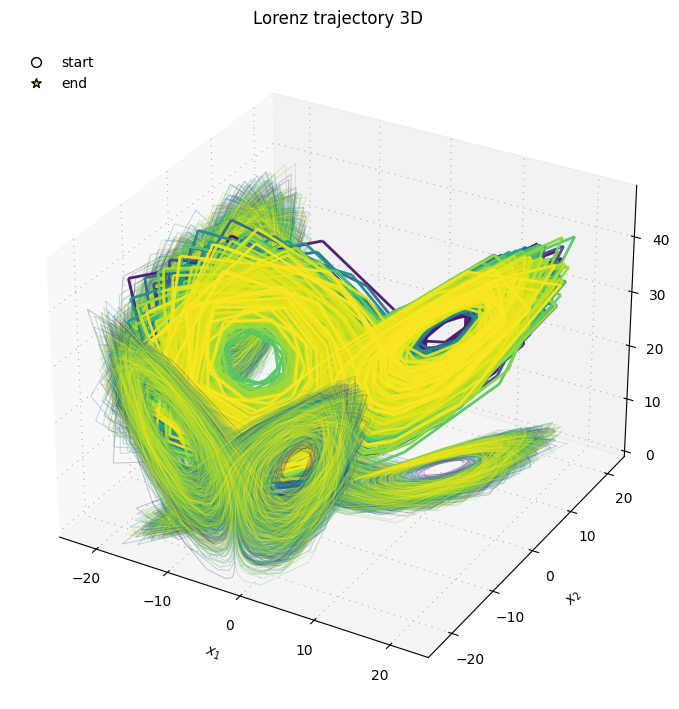

Saved lorenz_fancy_3d.png


In [10]:
# =========================================
# Fancy Lorenz trajectory plots (3D + 2D)
# Saves: lorenz_fancy_3d.png, lorenz_fancy_x1x2.png
# =========================================
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from mpl_toolkits.mplot3d.art3d import Line3DCollection
from matplotlib.colors import Normalize

# ---- pick a trajectory: prefer X_true_eval, else mean_truth, else X_truth ----
if 'X_true_eval' in globals():
    traj = X_true_eval.detach().cpu().numpy()
elif 'mean_truth' in globals():
    traj = mean_truth
elif 'X_truth' in globals():
    traj = X_truth.detach().cpu().numpy()
else:
    raise RuntimeError("No trajectory found. Provide X_true_eval, mean_truth, or X_truth.")

x = traj[:,0]; y = traj[:,1]; z = traj[:,2]
t = np.linspace(0, 1, len(traj))  # normalized time for coloring
norm = Normalize(0, 1)
cmap = plt.get_cmap('viridis')

def make_3d_segments(x, y, z):
    P = np.array([x, y, z]).T
    return np.stack([P[:-1], P[1:]], axis=1)  # (N-1, 2, 3)

# ------------- 3D plot -------------
fig = plt.figure(figsize=(8.5, 7.2))
ax = fig.add_subplot(111, projection='3d')

# main ribbon (colored by time)
segments3d = make_3d_segments(x, y, z)
colors3d = cmap(norm(t[:-1]))
lc3d = Line3DCollection(segments3d, colors=colors3d, linewidths=2.0, alpha=0.95)
ax.add_collection(lc3d)

# subtle projections on walls (xy, xz, yz)
offset = 0.02
xpad = (x.max() - x.min())*offset
ypad = (y.max() - y.min())*offset
zpad = (z.max() - z.min())*offset

# XY projection at z_min - pad
z0 = z.min() - zpad
seg_xy = make_3d_segments(x, y, np.full_like(z, z0))
lc_xy = Line3DCollection(seg_xy, colors=cmap(norm(t[:-1])), linewidths=0.8, alpha=0.25)
ax.add_collection(lc_xy)

# XZ projection at y_min - pad
y0 = y.min() - ypad
seg_xz = make_3d_segments(x, np.full_like(y, y0), z)
lc_xz = Line3DCollection(seg_xz, colors=cmap(norm(t[:-1])), linewidths=0.8, alpha=0.25)
ax.add_collection(lc_xz)

# YZ projection at x_min - pad
x0 = x.min() - xpad
seg_yz = make_3d_segments(np.full_like(x, x0), y, z)
lc_yz = Line3DCollection(seg_yz, colors=cmap(norm(t[:-1])), linewidths=0.8, alpha=0.25)
ax.add_collection(lc_yz)

# start/end markers
ax.scatter([x[0]],[y[0]],[z[0]], s=50, marker='o', edgecolor='k', facecolor='white', zorder=5, label='start')
ax.scatter([x[-1]],[y[-1]],[z[-1]], s=50, marker='*', edgecolor='k', facecolor='gold',  zorder=6, label='end')

# equal aspect
def set_equal_3d(ax, X, Y, Z):
    xr = X.max()-X.min(); yr = Y.max()-Y.min(); zr = Z.max()-Z.min()
    r = max(xr, yr, zr)/2
    xm = (X.max()+X.min())/2; ym = (Y.max()+Y.min())/2; zm = (Z.max()+Z.min())/2
    ax.set_xlim(xm-r, xm+r); ax.set_ylim(ym-r, ym+r); ax.set_zlim(zm-r, zm+r)

set_equal_3d(ax, x, y, z)

# styling
ax.set_xlabel(r'$x_1$', labelpad=8)
ax.set_ylabel(r'$x_2$', labelpad=8)
ax.set_zlabel(r'$x_3$', labelpad=8)
ax.set_title('Lorenz trajectory 3D', pad=14)

# light grid and reduced panes
ax.xaxis._axinfo["grid"]['linestyle'] = (0,(1,5))
ax.yaxis._axinfo["grid"]['linestyle'] = (0,(1,5))
ax.zaxis._axinfo["grid"]['linestyle'] = (0,(1,5))
ax.legend(frameon=False, loc='upper left')

fig.tight_layout()
fig.savefig("lorenz_fancy_3d.png", dpi=200, bbox_inches='tight')
plt.show()
print("Saved lorenz_fancy_3d.png")

